## MNIST classification NN

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
torch.__version__

'2.9.1'

In [2]:
PLOT_COLOR_NEUTRAL = '#344c63'
PLOT_COLOR_GOOD = '#62cc7e'
PLOT_COLOR_BAD = '#cf4d46' 

INTERPRETATION_BATCH_SIZE = 10

In [3]:
dataset_train = datasets.MNIST("data", download=True, train=True, transform=transforms.ToTensor())
dataset_test = datasets.MNIST("data", download=True, train=False, transform=transforms.ToTensor())

x_train, y_train = dataset_train.data.to(dtype=torch.float), dataset_train.targets
x_test, y_test = dataset_test.data.to(dtype=torch.float), dataset_test.targets

softmax = nn.Softmax(dim=0)
relu = nn.ReLU()

plt.rcParams['image.cmap'] = 'gray'

5


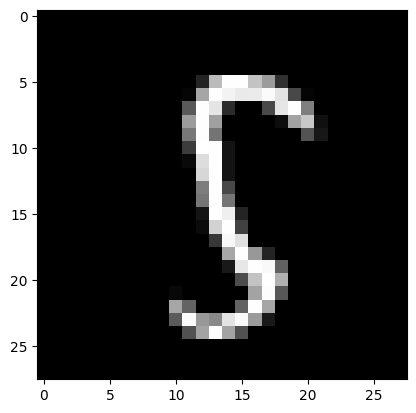

In [4]:
n = random.randint(0, len(x_train))
print(y_train[n].item())
plt.imshow(x_train[n])

In [5]:
x_train[0].shape

torch.Size([28, 28])

In [6]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self, channels=8, kernel_size=5, stride=1, pool_size=2, pool_stride=2):
        super(MNISTClassifier, self).__init__()
        self.in_channels = 1  # MNIST pictures are grayscale 
        self.flatten = nn.Flatten()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(8, 16, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(3, 3),
            nn.Flatten(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.pipeline(x)

In [7]:
classifier = MNISTClassifier()

[0.009283087216317654, 2.679740873645642e-06, 0.0020771289709955454, 0.0006877646083012223, 0.003706293646246195, 4.3668416765285656e-05, 0.0003335809160489589, 2.3775162105721392e-07, 0.001837540534324944, 0.9820280075073242]


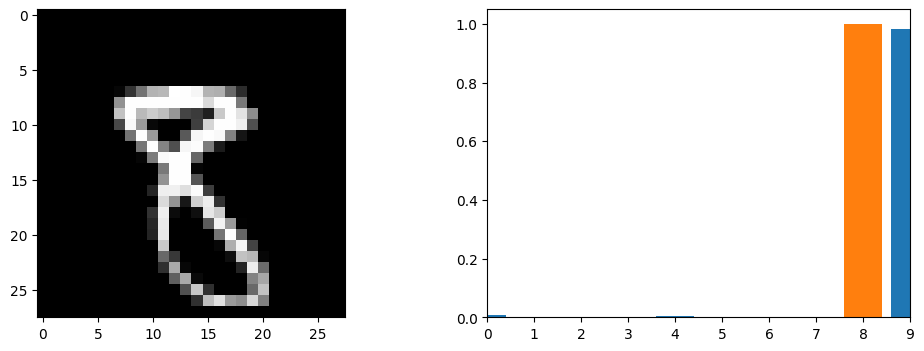

In [8]:
def predict_random_from_train(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_train))
        ax[0].imshow(x_train[n])
        y_sample = (net.forward(x_train[n].unsqueeze(0).unsqueeze(0))).squeeze()
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_train[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample


def predict_random_from_test(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_test))
        ax[0].imshow(x_test[n])
        y_sample = ((net.forward(x_test[n].unsqueeze(0).unsqueeze(0))).squeeze())
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_test[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample 

y_sample = predict_random_from_test(classifier, apply_softmax=True)
print(y_sample.tolist())

In [9]:
def predict(net: torch.nn.Module, x): 
    return net.forward(x.unsqueeze(1))

with torch.no_grad():
    print(softmax(predict(classifier, x_train).squeeze()))

tensor([[1.3493e-05, 7.4420e-05, 8.3364e-06,  ..., 3.8964e-07, 6.9772e-05,
         3.1947e-06],
        [2.2581e-05, 2.0747e-05, 4.4736e-06,  ..., 3.6193e-06, 9.8247e-06,
         1.4175e-06],
        [3.4358e-06, 6.8993e-05, 1.9499e-05,  ..., 7.3130e-05, 5.8999e-07,
         7.6375e-08],
        ...,
        [1.4838e-04, 7.7144e-05, 1.0071e-05,  ..., 3.4623e-07, 6.3882e-05,
         1.7857e-05],
        [7.3456e-06, 1.8760e-05, 6.3464e-06,  ..., 2.2970e-06, 5.2689e-05,
         2.2049e-07],
        [2.8805e-06, 1.2930e-06, 1.4871e-06,  ..., 8.2970e-07, 3.4202e-05,
         1.0741e-06]])


epoch 0, loss 0.2918274975963868


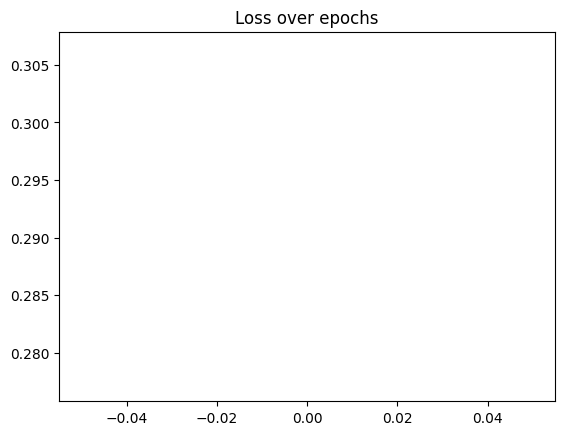

In [10]:
def fit(classifier, epochs=20, verbose=True):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-2)
    loss = nn.CrossEntropyLoss()

    history = []
    train_loader = DataLoader(dataset_train, batch_size=512, shuffle=True, num_workers=2)

    for epoch in range(0, epochs):
        epoch_loss = 0

        for x_batch, y_true_batch in train_loader:
            optimizer.zero_grad()
            logits = classifier.forward(x_batch)
            
            loss_val = loss(logits, y_true_batch)
            loss_val.backward()
            
            optimizer.step()
            epoch_loss += loss_val.item()

        epoch_loss /= train_loader.batch_size
        history.append(epoch_loss)

        if verbose:
            print(f'epoch {epoch}, loss {epoch_loss}')
    
    return history

e = 1
history = fit(classifier, e)

plt.title("Loss over epochs")
plt.plot(torch.arange(0, e), history)

In [11]:
# Counting accuracy
def calculate_accuracy(classifier, x_test, y_test):
    with torch.no_grad():
        predicted = torch.argmax(classifier.forward(x_test.unsqueeze(1)), dim=1)
        accuracy = ((predicted == y_test).sum() / y_test.shape[0]).item()
    return accuracy
    
calculate_accuracy(classifier, x_test, y_test)

0.7813000082969666

In [12]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().squeeze(0)
    return hook

classifier.pipeline[3].register_forward_hook(get_activation('conv2'))

In [13]:
'''
    Here we've come up to the theoretical part
    Assuming Flatten() doesn't change gradients, we can get gradients of linear layer 
'''

def build_heatmap(net, image: Tensor, c=0):
    y = net.forward(image)
    y_c = y[0][c]
    y_c.backward()

    d_yc_d_linear = classifier.pipeline[-1].weight.grad[c]
    d_yc_d_Map = lambda k: d_yc_d_linear[16 * (k - 1) : 16 * k - 1]
    
    alpha_c = torch.zeros(16)
    heatmap = torch.zeros_like(activation['conv2'][0])
    for k in range(16):
        alpha_c[k] = d_yc_d_Map(k).mean()
        activation_map = activation['conv2'][k]
        heatmap += alpha_c[k].item() * activation_map

    return relu(heatmap).detach()

In [14]:
'''
    Here we've come up to the theoretical part
    Assuming Flatten() doesn't change gradients, we can get gradients of linear layer 
'''

def build_heatmap(net, image: Tensor, c=0):
    y = net.forward(image)
    y_c = y[0][c]
    y_c.backward()

    d_yc_d_linear = classifier.pipeline[-1].weight.grad[c]
    d_yc_d_Map = lambda k: d_yc_d_linear[16 * (k - 1) : 16 * k - 1]
    
    alpha_c = torch.zeros(16)
    heatmap = torch.zeros_like(activation['conv2'][0])
    for k in range(16):
        alpha_c[k] = d_yc_d_Map(k).mean()
        activation_map = activation['conv2'][k]
        heatmap += alpha_c[k].item() * activation_map

    return relu(heatmap).detach()

tensor(-0.7605)

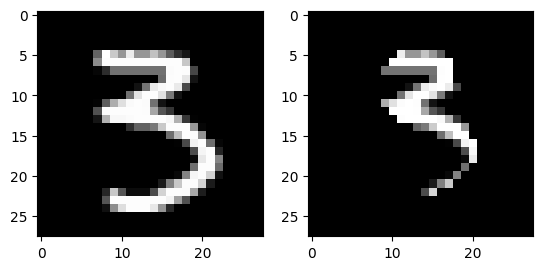

In [64]:
def fidelity(net, image, heatmap, threshold = 5/6, verbose=False):
    acc = 0
    with torch.no_grad():
        f_x = net.forward(image.unsqueeze(0).unsqueeze(0))
        threshold = (torch.amax(heatmap) * threshold).item()
        masked_image = image.clone()
        masked_image[heatmap < threshold] = 0
        
        if (verbose):
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(image)
            ax[1].imshow(masked_image)
        
        f_xm = net.forward(masked_image.unsqueeze(0).unsqueeze(0))
        return (f_x - f_xm).mean()

fidelity(classifier, images[0], heatmaps[0], threshold=3/5, verbose=True)

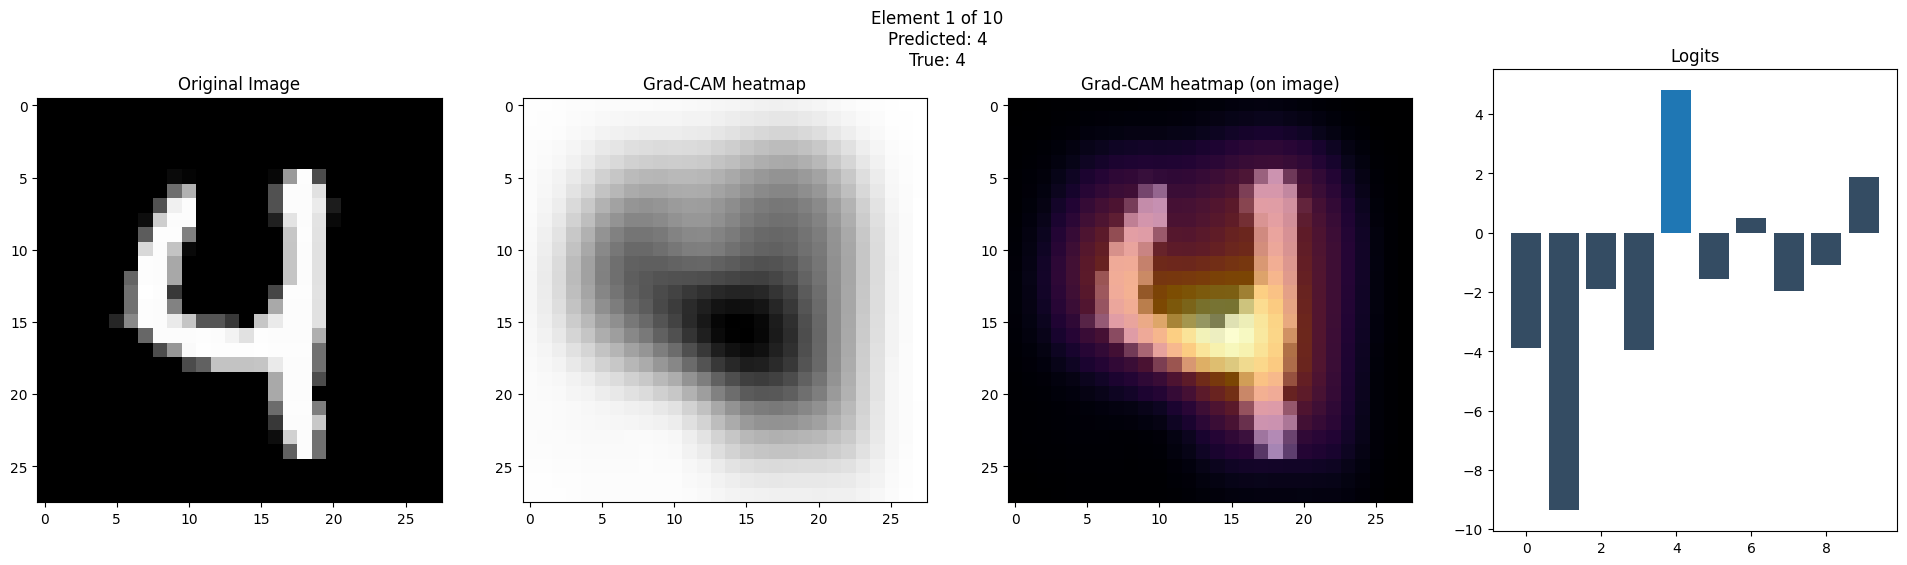

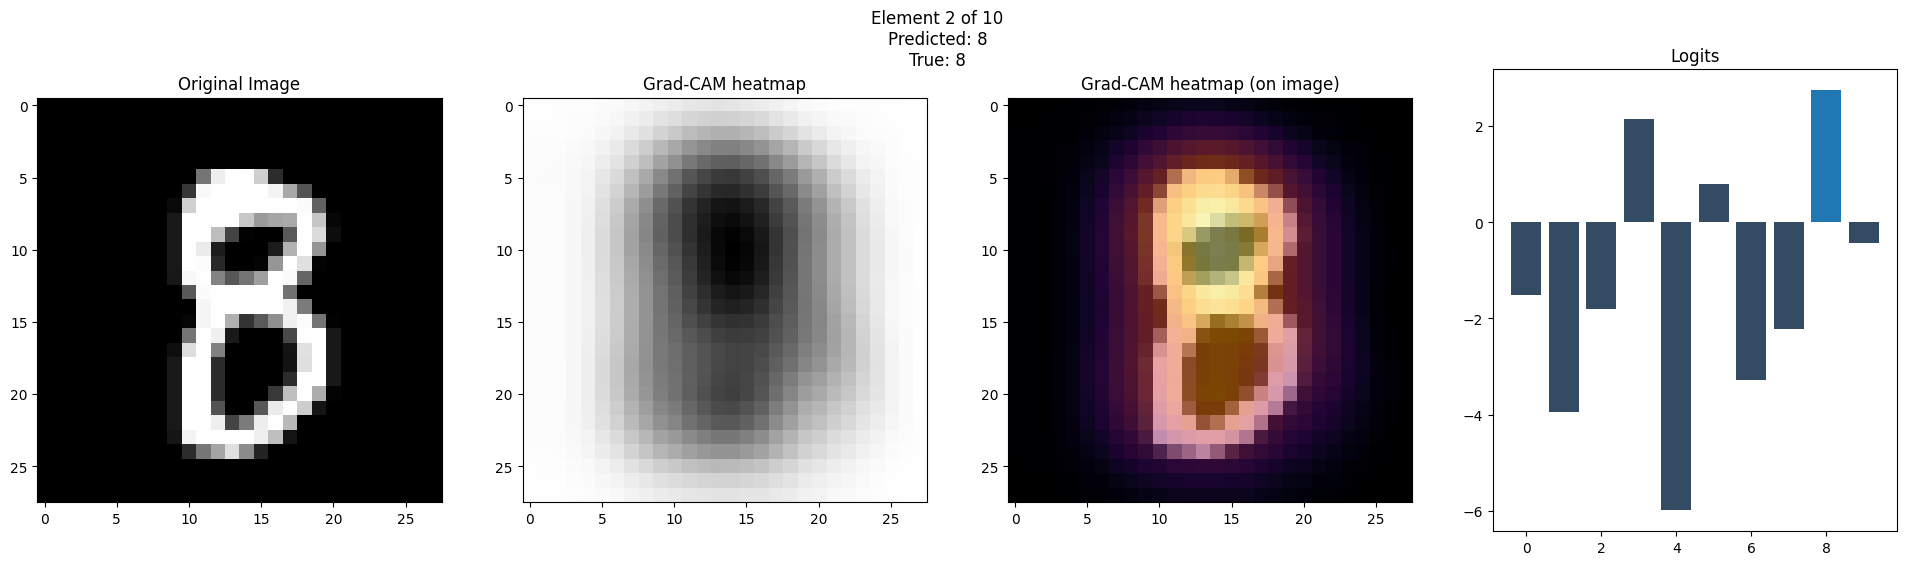

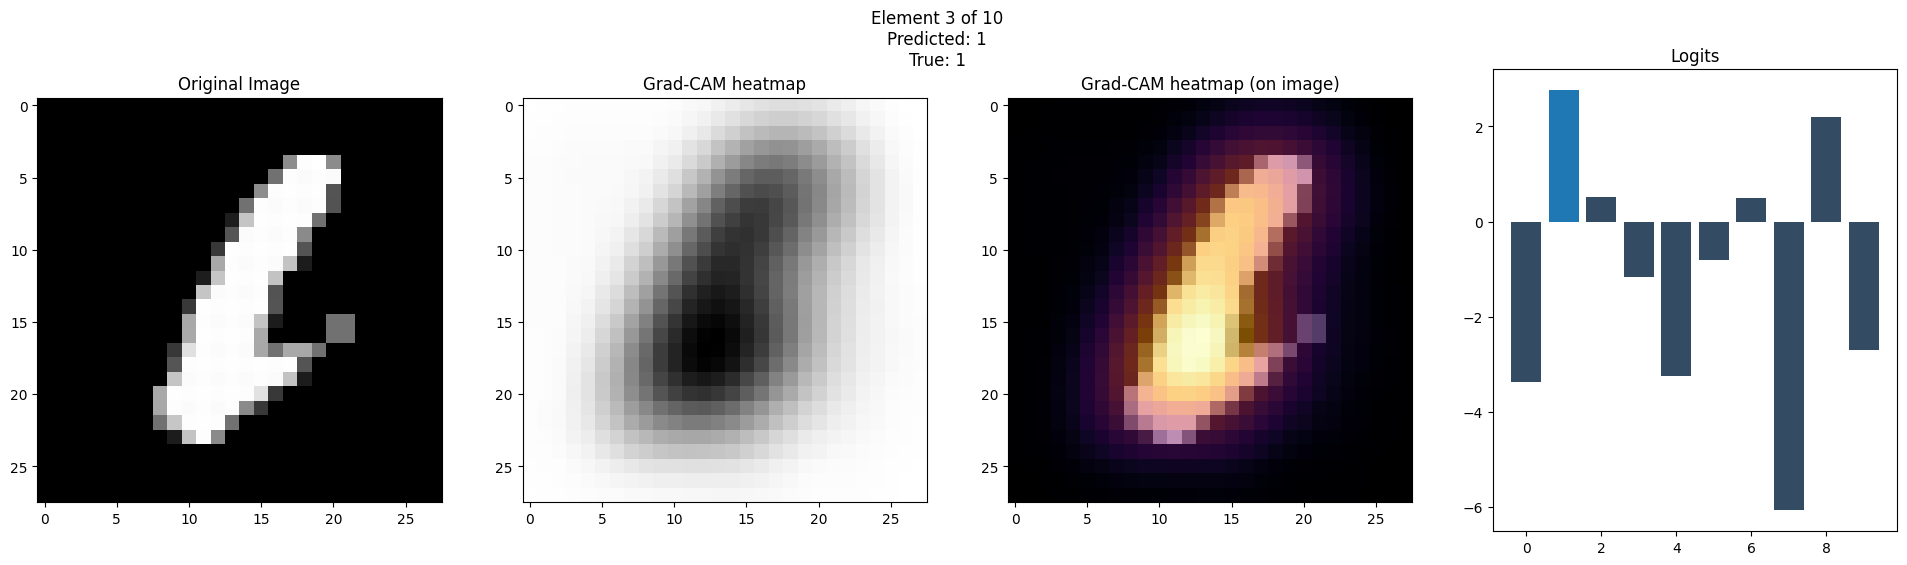

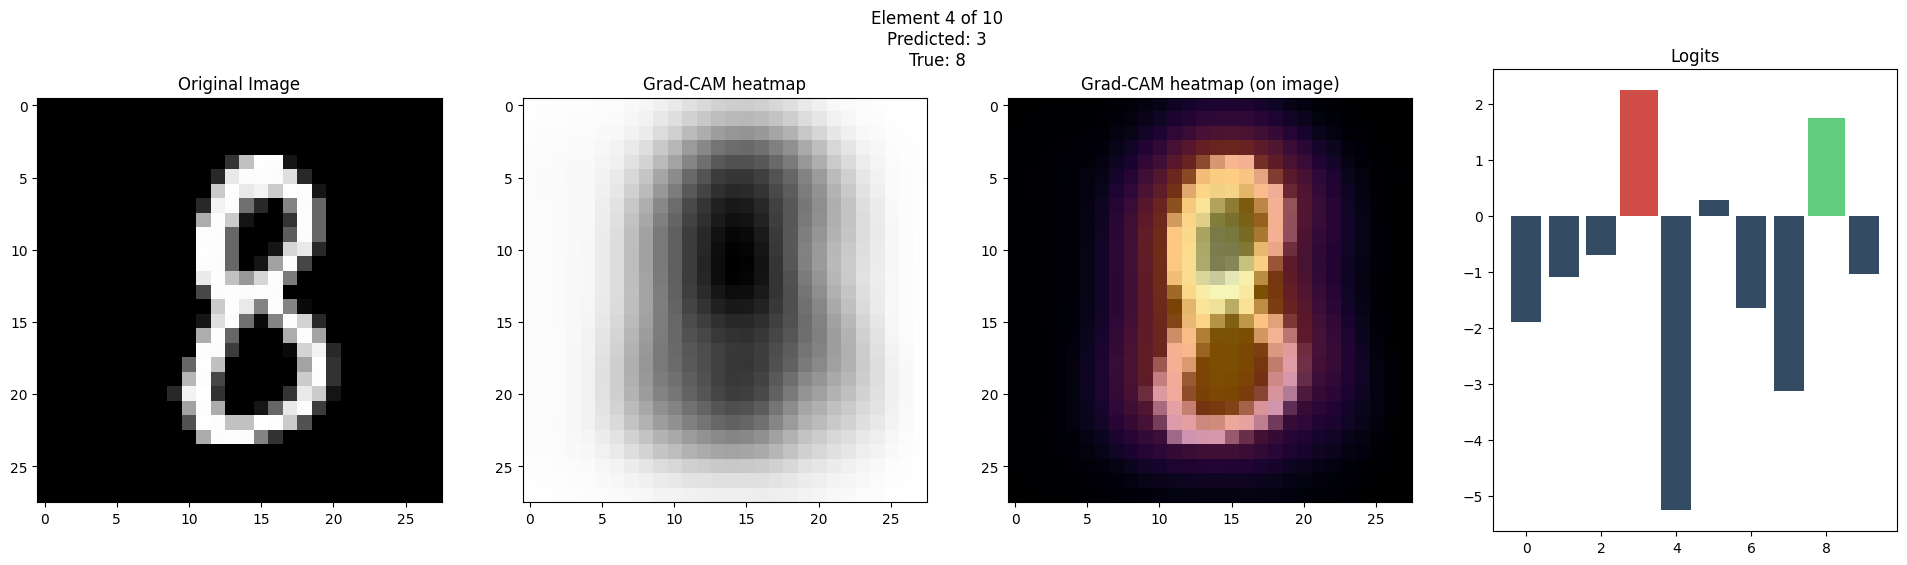

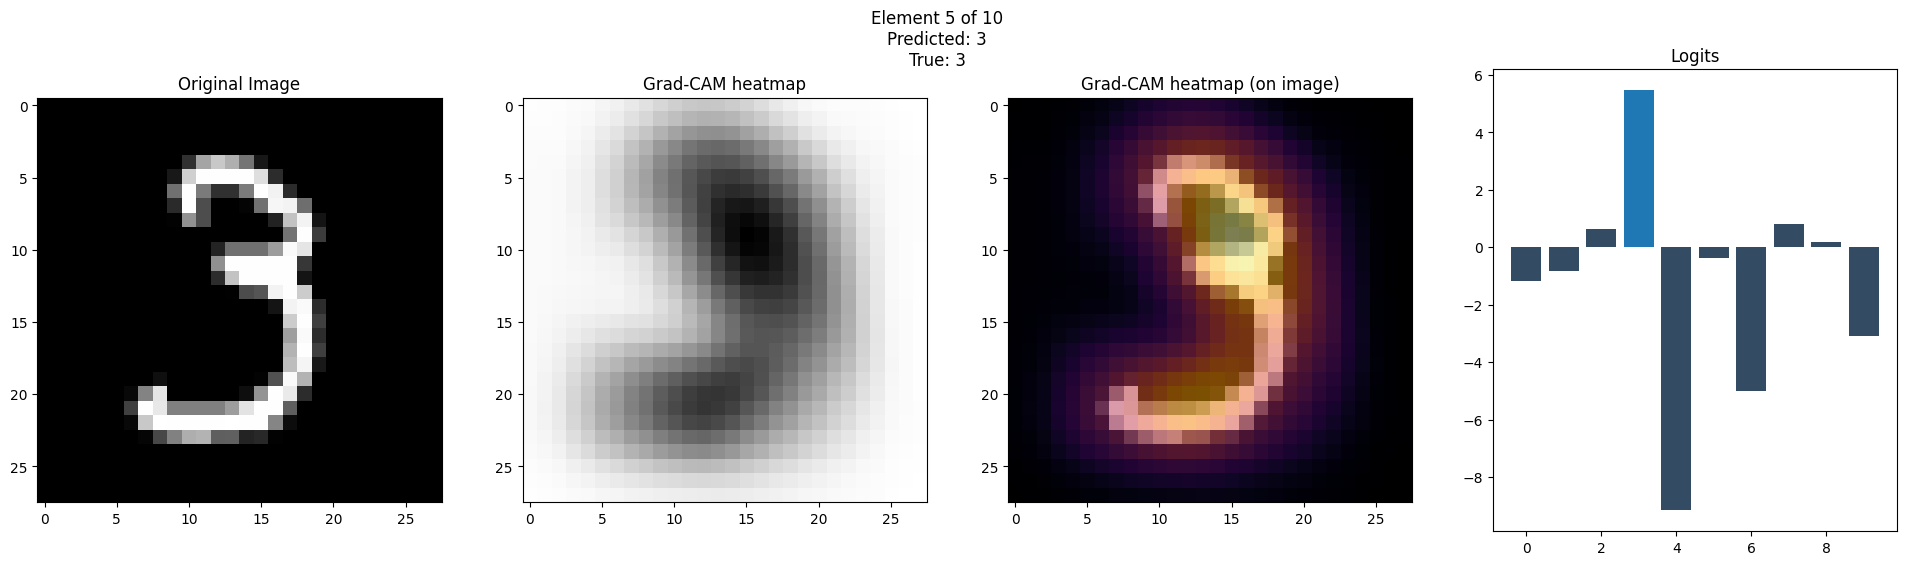

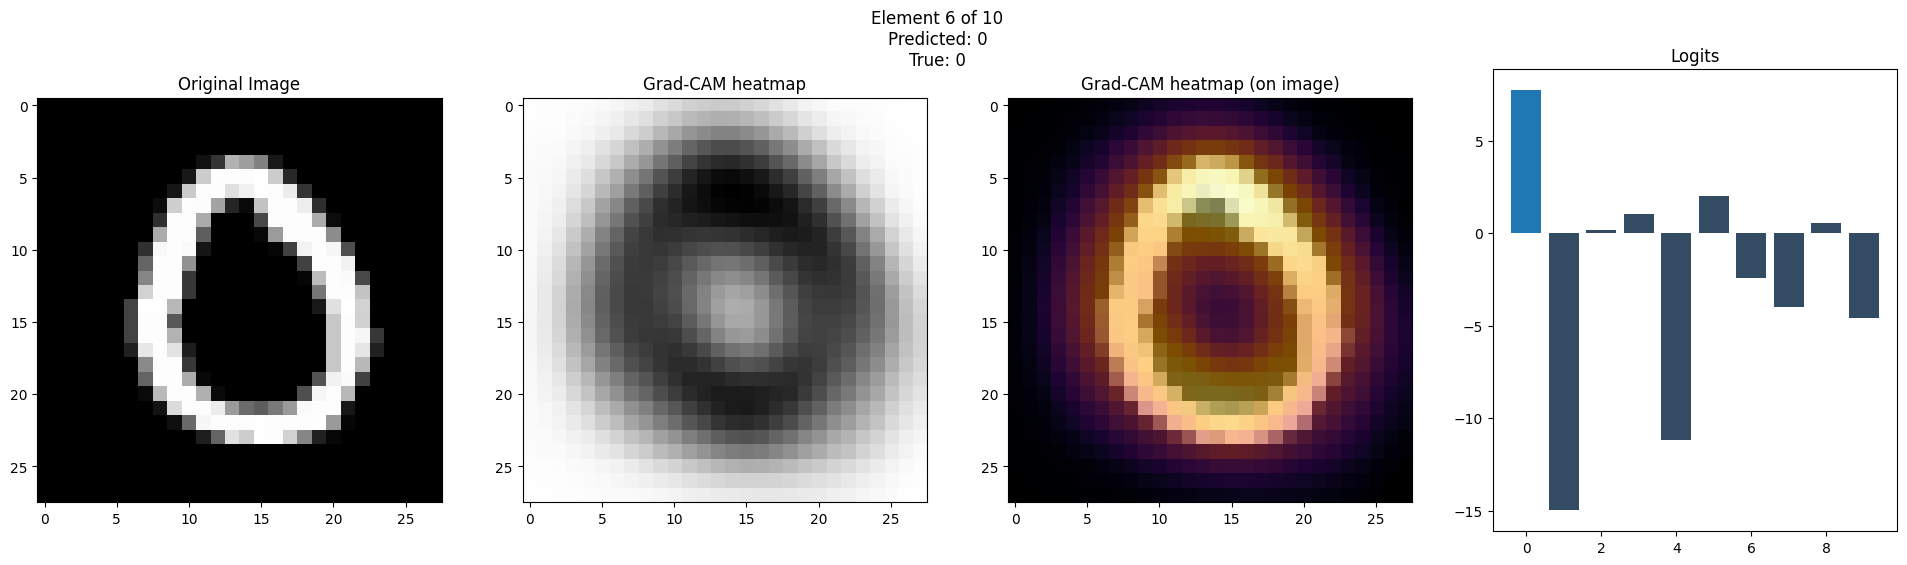

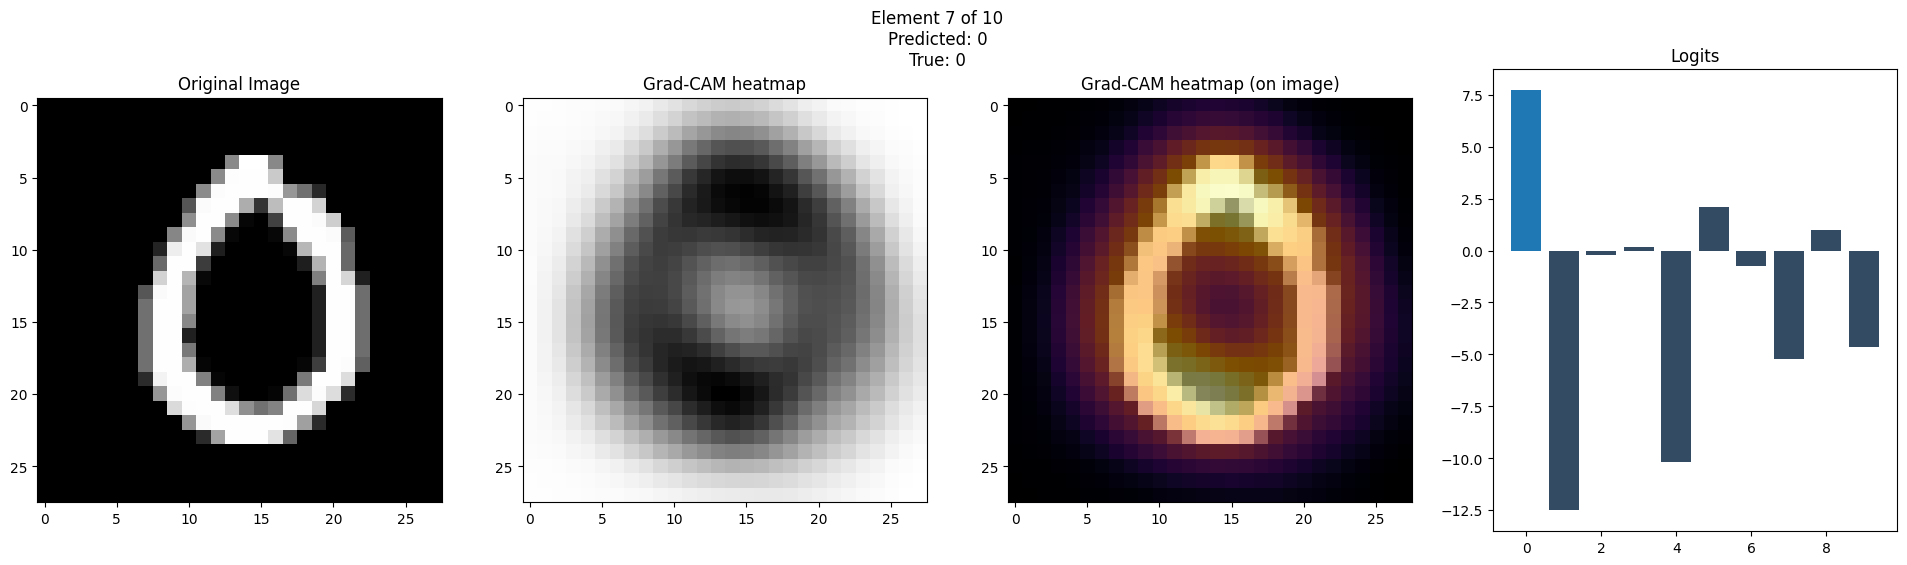

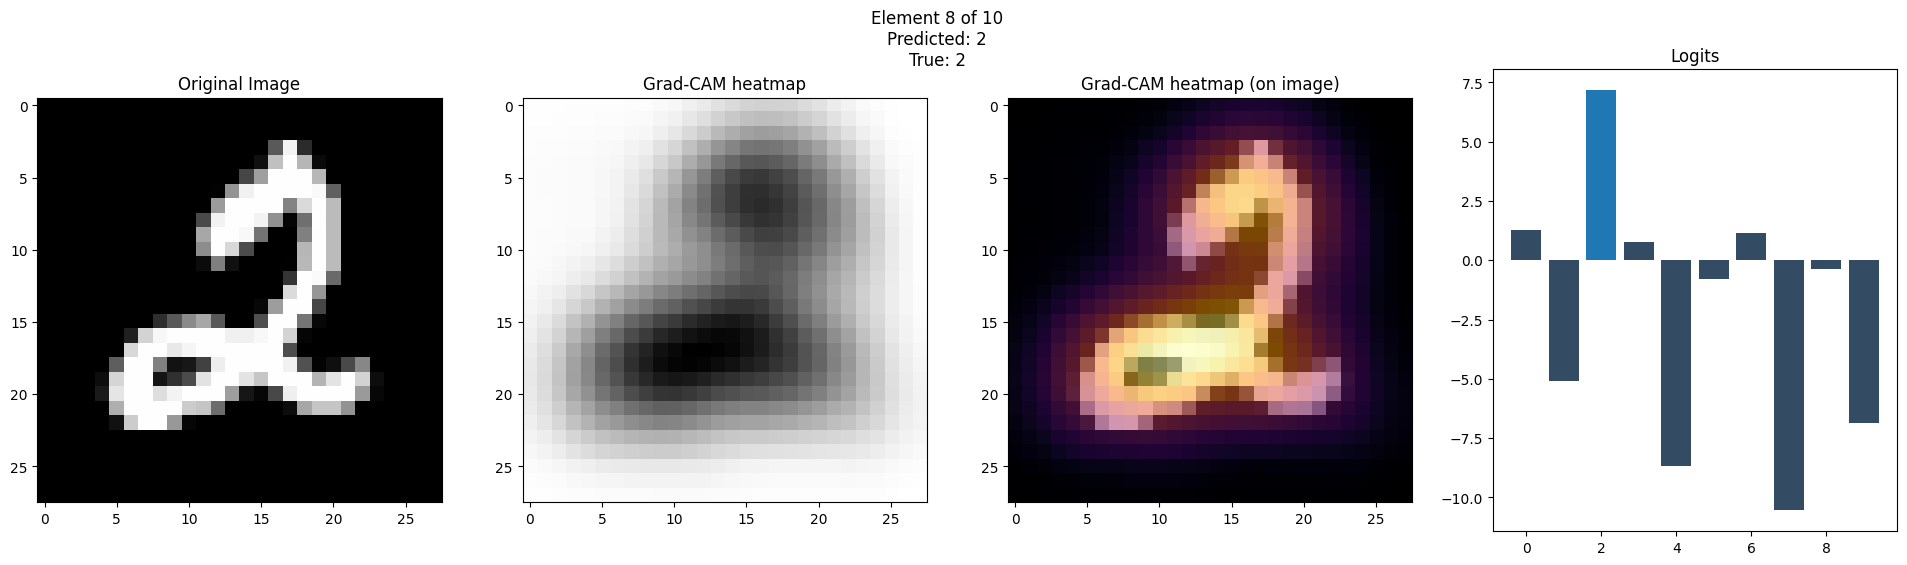

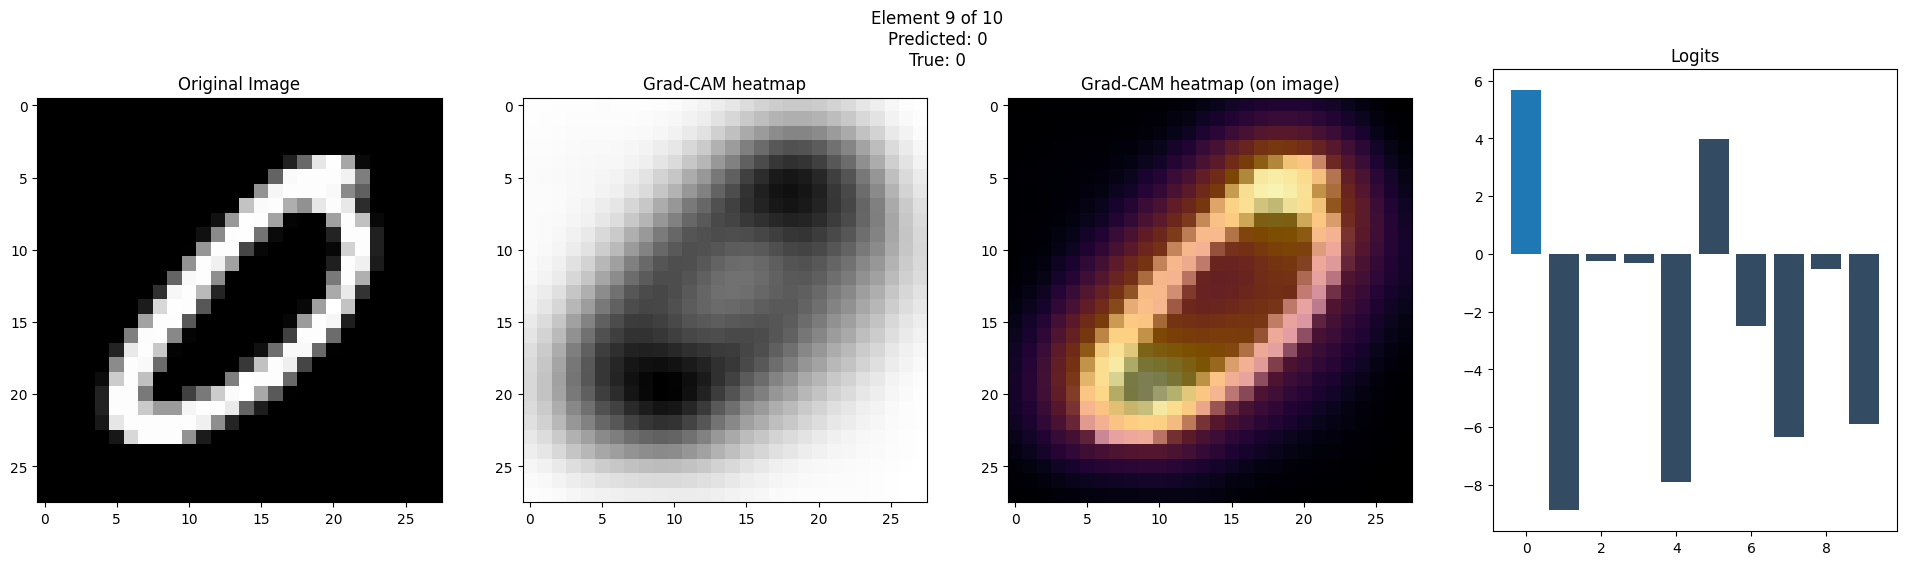

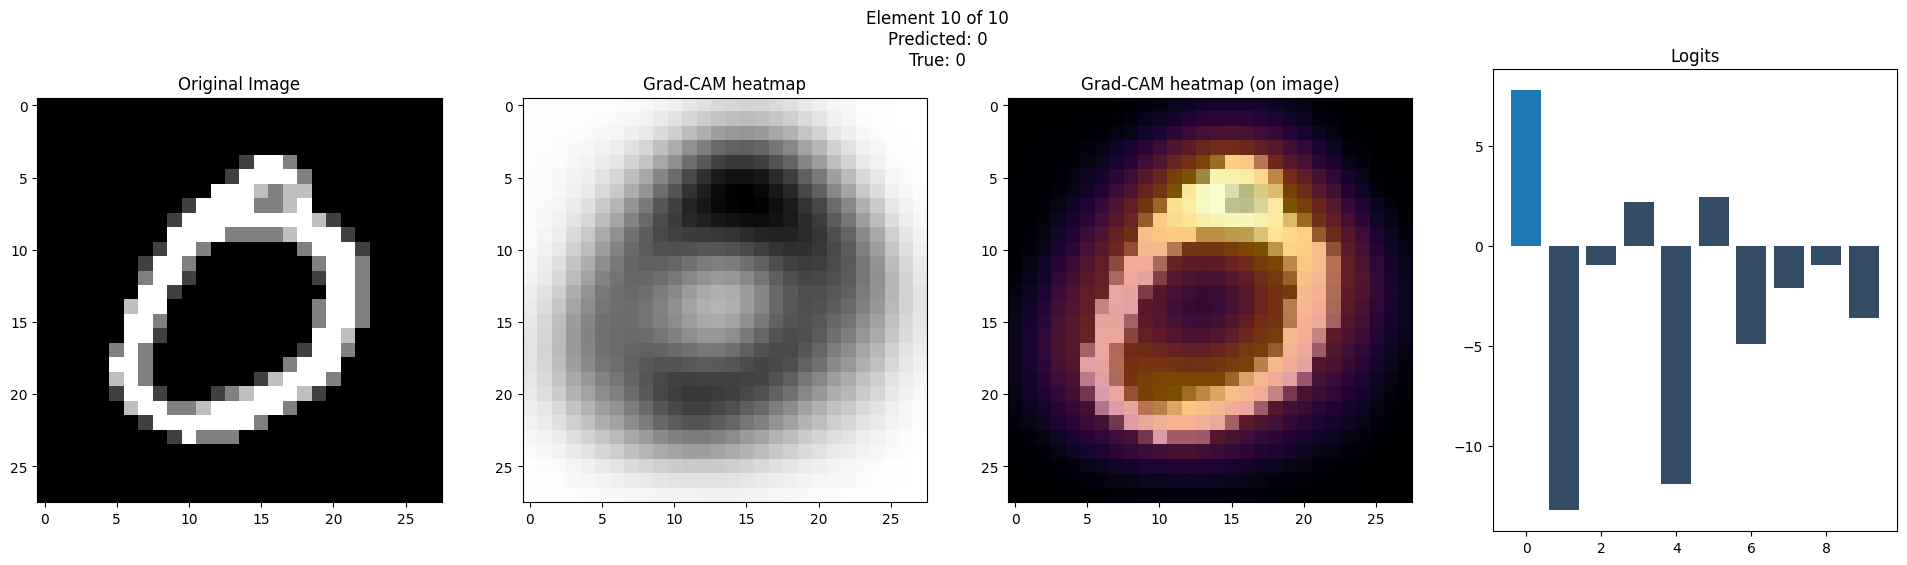

In [67]:
validation_batch = DataLoader(dataset_test, batch_size=INTERPRETATION_BATCH_SIZE, num_workers=2, shuffle=True)

x_batch, y_batch = next(validation_batch._get_iterator())

images = []
heatmaps = []

fidelities = torch.zeros(INTERPRETATION_BATCH_SIZE)
threshold = 5/6

for n in range(len(x_batch)):
    x_sample = x_batch[n].unsqueeze(0)

    y_true_sample = y_batch[n].squeeze(0)
    y_pred_sample_logits = classifier.forward(x_sample).detach().squeeze()
    y_pred_sample = y_pred_sample_logits.argmax()
    
    heatmap = build_heatmap(classifier, x_sample, c=y_true_sample)
    x_sample = x_sample.squeeze(0).squeeze(0)
    
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    fig.suptitle(f'Element {n + 1} of {INTERPRETATION_BATCH_SIZE}\nPredicted: {y_pred_sample}\nTrue: {y_true_sample}')

    ax[0].set_title("Original Image")
    ax[0].imshow(x_sample)
    ax[1].set_title("Grad-CAM heatmap")
    ax[1].imshow(-F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='bicubic')[0][0])
    ax[2].set_title("Grad-CAM heatmap (on image)")
    
    scaled_heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='bicubic')[0][0]
    
    ax[2].imshow(x_sample)
    ax[2].imshow(scaled_heatmap, alpha=0.5, cmap='inferno')
    ax[3].set_title(f"Logits")
    ax[3].bar(x=torch.arange(0, 10), height=y_pred_sample_logits, color=PLOT_COLOR_NEUTRAL)
    ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_logits))
    
    if y_pred_sample != y_true_sample:
        ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_logits), width=1, color=PLOT_COLOR_BAD)
        ax[3].bar(x=y_true_sample, height=y_pred_sample_logits[y_true_sample], width=1, color=PLOT_COLOR_GOOD)

    images.append(x_sample)
    heatmaps.append(scaled)
    fidelities[n] = fidelity(classifier, x_sample, scaled_heatmap, threshold)

In [74]:
f_mean = fidelities.mean().item()
D = ((fidelities - torch.full(fidelities.shape, f_mean))**2).mean()
print(f'Mean: {f_mean}')
print(f'D: {D}')

Mean: -1.2254390716552734
D: 0.16729769110679626
